In [1]:
import sys
sys.path[0]="/Users/kwaneu/research/velocity/"
#print(sys.path)
import pandas as pd
import numpy as np
import velocity
from velocity.chemistry import Species, Reaction, Network
from math import sqrt
import lmfit
from tqdm.notebook import tqdm
from IPython.display import display, HTML
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

['/Users/kwaneu/research/velocity/', '/Users/kwaneu/research/velocity/sugar/sugar_grid', '/Users/kwaneu/miniconda3/envs/python/lib/python39.zip', '/Users/kwaneu/miniconda3/envs/python/lib/python3.9', '/Users/kwaneu/miniconda3/envs/python/lib/python3.9/lib-dynload', '', '/Users/kwaneu/miniconda3/envs/python/lib/python3.9/site-packages', '/Users/kwaneu/miniconda3/envs/python/lib/python3.9/site-packages/IPython/extensions', '/Users/kwaneu/.ipython']


In [2]:
# settings
observations_filename = "observations.xlsx"  # spreadsheet filename

# parameter bounds
min_log10_base_rate_constant = -3
max_log10_base_rate_constant = -1
min_log10_selectivity = -2
max_log10_selectivity = 2
min_log10_catalyst_deactivation_rate_constant = -6
default_log10_catalyst_deactivation_rate_constant = np.log10(0.000014)
max_log10_catalyst_deactivation_rate_constant = -4

In [3]:
# setup sugars
glucose = Species("Glc", "glucose")
mannose = Species("Man", "mannose")
altrose = Species("Alt", "altrose")
allose = Species("All", "allose")
gulose = Species("Gul", "gulose")
galactose = Species("Gal", "galactose")
talose = Species("Tal", "talose")
idose = Species("Ido", "idose")

# must match order in spreadsheet!
sugars = [ glucose, mannose, allose, galactose, altrose, talose, gulose, idose ]
sugars_dict = { s.abbreviation : s for s in sugars }
sugar_abbreviations = [ s.abbreviation for s in sugars ]

# setup catalyst
catalyst_active = Species("cat", "catalyst (active)")
catalyst_dead = Species("dead", "catalyst (dead)")

# these are the network connections
CONNECTIONS = ["Glc_All",  "Glc_Gal",  "Glc_Man",
               "All_Gul",  "Gul_Gal",  "Gal_Tal",
               "Tal_Man",  "Man_Alt",  "Alt_All",
               "Alt_Ido",  "Tal_Ido",  "Ido_Gul"]

In [4]:
def add_connection(reactions_dict, connection_string, base_rate_constant, selectivity):
    sugar1, sugar2 = connection_string.split("_")
    sugar1 = sugars_dict[sugar1]
    sugar2 = sugars_dict[sugar2]

    jk1 = base_rate_constant*sqrt(selectivity)
    jk2 = base_rate_constant/sqrt(selectivity)
    reaction = Reaction({sugar1:1, catalyst_active:1}, {sugar2:1, catalyst_active:1}, reversible=True)
    reactions_dict[reaction] = (jk1,jk2)

In [5]:
def create_network(x):
    reactions_dict = {}

    for connection in CONNECTIONS:
        base_rate_constant = np.power(10, x[f"{connection}_log10_base_rate_constant"])
        selectivity = np.power(10, x[f"{connection}_log10_selectivity"])
        add_connection(reactions_dict, connection, base_rate_constant, selectivity)

    catalyst_deactivation_reaction = Reaction(catalyst_active, catalyst_dead, reversible=False)
    reactions_dict[catalyst_deactivation_reaction] = np.power(10.0,x["log10_catalyst_deactivation_rate_constant"])
    
    network = Network(reactions_dict, fixed_concentrations=None)
    return network

In [80]:
def add_parameters(connection, base_rate_constant, selectivity, vary=(False,False)):
    vary_rate, vary_selectivity = vary
    parameter = lmfit.Parameter(
        name = f"{connection}_log10_base_rate_constant",
        min = min_log10_base_rate_constant,
        value = np.log10(base_rate_constant*1e-6),
        max = max_log10_base_rate_constant,
        vary = True
    )
    parameters.add(parameter)

    parameter = lmfit.Parameter(
        name = f"{connection}_log10_selectivity",
        min = min_log10_selectivity,
        value = np.log10(convert(selectivity)),
        max = max_log10_selectivity,
        vary = True
    )
    parameters.add(parameter)

In [62]:
# root mean square average
def rms(x):
    assert isinstance(x, (list,np.ndarray))
    assert len(x) > 0
    return np.sqrt(np.mean(np.square((x))))

In [63]:
def convert(selectivity):
    """Converts negative selectivites into inverse selectivities.

    Leaves positive selectivities untouched.

    Args:
        selectivity (int or float): The selectivity to convert.

    Returns:
        selectivity (float): The converted selectivity.
    """
    selectivity = float(selectivity)
    if selectivity < 0.0:
        selectivity = -1.0/selectivity
    return selectivity

In [64]:
# represents a single experimental isomerization run
class ExperimentalRun():
    def __init__(self, starting_sugar):
        assert starting_sugar in sugar_abbreviations, f"sugar {starting_sugar} not found"
        self.starting_sugar = sugars_dict[starting_sugar]
        self.observation_times = []          # list of floats
        self.observations = []               # list of np.array (float),
                                             # where the outer index parallels observation_times
                                             # and the inner index parallels sugars

    def add_observation(self, observation_time, observed_mole_fractions):
        assert isinstance(observation_time, (int,float)) and observation_time > 0.0
        self.observation_times.append(float(observation_time))
        assert isinstance(observed_mole_fractions, list)
        assert len(observed_mole_fractions) == len(sugars)
        for i in observed_mole_fractions:
            assert isinstance(i, (int,float)) and i >= 0.0
        observed_mole_fractions = np.array(observed_mole_fractions, dtype=float)
        observed_mole_fractions = observed_mole_fractions / np.sum(observed_mole_fractions)
        self.observations.append(observed_mole_fractions)

In [65]:
# read experimental data
observations_df = pd.read_excel(observations_filename)
expected_columns = ["Run", "Starting Sugar", "Time"]
expected_columns.extend(sugar_abbreviations)
assert np.all(observations_df.columns == expected_columns), "check spreadsheet columns"
current_run = None
current_run_number = None
experimental_runs = []
for _,row in observations_df.iterrows():
    run_number, starting_sugar, time, *observations = row
    if current_run is None:
        assert run_number == 1
        current_run = ExperimentalRun(starting_sugar)
        current_run_number = run_number
    elif run_number != current_run_number:
        assert run_number == current_run_number + 1
        experimental_runs.append(current_run)
        current_run = ExperimentalRun(starting_sugar)
        current_run_number = run_number
    else:
        assert starting_sugar == current_run.starting_sugar.abbreviation
    current_run.add_observation(time, observations)

if current_run:
    experimental_runs.append(current_run)

In [66]:
# generate times to run simulation over
all_times = set()
for r in experimental_runs:
    all_times.update(r.observation_times)
all_times = list(sorted(all_times))
t_span = (0.0, all_times[-1])
t_eval = np.array(all_times)
print(f"Read {len(experimental_runs)} experimental runs.")
print(f"Will evaluate these times within {t_span} s:")
print(all_times)
print()

Read 8 experimental runs.
Will evaluate these times within (0.0, 64800.0) s:
[1200.0, 1800.0, 2400.0, 4920.0, 9720.0, 16920.0, 64800.0]



In [67]:
# run simulations
def run_simulations():
    network = create_network(parameters)
    for run in experimental_runs:
        initial_concentrations_dict = {
            run.starting_sugar : 0.2,
            catalyst_active : 0.2*0.02,
        }
        concentrations_df = network.simulate_timecourse(initial_concentrations_dict, t_span, t_eval)
        run.simulation_df = concentrations_df

In [68]:
def plot():
    titles = [ e.starting_sugar.description for e in experimental_runs ]
    fig = make_subplots(rows=2, cols=4, subplot_titles=titles, vertical_spacing=0.2, horizontal_spacing=0.03)
    for i,experimental_run in enumerate(experimental_runs):
        # interleave observed and simulated data
        simulation_df = experimental_run.simulation_df[sugar_abbreviations]
        observation_times = experimental_run.observation_times
        data_rows, labels = [], []
        for j,experimental_observations in enumerate(experimental_run.observations):
            data_rows.append(experimental_observations)
            labels.append(f"exp:{t_eval[j]:.0f} s")
            simulated_row = simulation_df.loc[observation_times[j]].to_numpy()
            data_rows.append(simulated_row / np.sum(simulated_row))
            labels.append(f"sim:{t_eval[j]:.0f} s")
        results_df = pd.DataFrame(data_rows, index=labels, columns=sugar_abbreviations)

        # create the bar objects
        row = i // 4 + 1
        col = i % 4 + 1
        count = -1
        colors = ["red","blue"] * len(experimental_run.observations)
        for label,df_row in results_df.iterrows():
            count += 1 
            bar = go.Bar(name=label, x=sugar_abbreviations, y=df_row, marker_color=colors[count])
            fig.add_trace(bar, row=row, col=col)
        fig.update_yaxes(range=[0,1], row=row, col=col)

    fig.update_layout(barmode="group", showlegend=False, height=400, width=1400)
    fig.show()
    

In [69]:
# calculate the loss for a single simulation
# treats all runs with same weight regardless of number of observations
def loss_function(experimental_run, concentrations_df):
    losses = []
#    print("============")
    for t,observed in zip(experimental_run.observation_times, experimental_run.observations):
        df = concentrations_df.query(f"index == {t}")
        assert len(df) == 1
        simulated = df[sugar_abbreviations]
#         display(simulated)
        simulated = simulated.iloc[0].to_numpy()
        simulated = simulated / np.sum(simulated)
#         print([f"{i:.3f}" for i in simulated])
#         print([f"{i:.3f}" for i in observed])
#         print("---")
#         print("Simulated:")
#         print(simulated)
#         print("Obeserved:")
#         print(observed)
#         print("diff:")
#         print(simulated-observed)
#         print("rms:")
        loss = rms(simulated-observed)
#         print(loss)
        losses.append(loss)
    # print("LOSSES")
    # print(losses)
    # print(rms(losses))
    return rms(losses)

In [70]:
'''
add_parameters("Glc_All",  50000,  10)
add_parameters("Glc_Gal",  10000,   1)
add_parameters("Glc_Man",  10000,   1)
add_parameters("All_Gul",  10000,  -5)
add_parameters("Gul_Gal",  10000,   1)
add_parameters("Gal_Tal",   2000,  10)
add_parameters("Tal_Man",  20000, -10)
add_parameters("Man_Alt",  10000,   1)
add_parameters("Alt_All",  10000,  10)
add_parameters("Alt_Ido",  10000,   1)
add_parameters("Tal_Ido",  10000, -10)
add_parameters("Ido_Gul",  10000,   1)

add_parameters("Glc_All",  50000,  10)
add_parameters("Glc_Gal",   1000,   1, (True,True))
add_parameters("Glc_Man",   1000,   1, (False,True))
add_parameters("All_Gul",  10000,  -5)
add_parameters("Gul_Gal",   3000,   4, (True,True))
add_parameters("Gal_Tal",  10000,  10, (True,False))
add_parameters("Tal_Man",  20000, -10)
add_parameters("Man_Alt",  10000,   1)
add_parameters("Alt_All",  10000,  10)
add_parameters("Alt_Ido",   1000,   1)
add_parameters("Tal_Ido",  10000, -10)
add_parameters("Ido_Gul",   1000,   1)

add_parameters("Glc_All",  44000,  10, (True,False))
add_parameters("Glc_Gal",   1000,  1,  (True,False))
add_parameters("Glc_Man",   1000,  1,  (True,False))
add_parameters("All_Gul",   7000, -10, (True,False))
add_parameters("Gul_Gal",  12000,  1,  (True,False))
add_parameters("Gal_Tal",  12000,  10, (True,False))
add_parameters("Tal_Man",  15000, -10, (True,False))
add_parameters("Man_Alt",  25000,  1,  (True,False))
add_parameters("Alt_All",   4900,  10, (True,False))
add_parameters("Alt_Ido",   1000,  1,  (True,False))
add_parameters("Tal_Ido",   6500, -10, (True,False))
add_parameters("Ido_Gul",   1000,  1,  (True,False))
'''

'\nadd_parameters("Glc_All",  50000,  10)\nadd_parameters("Glc_Gal",  10000,   1)\nadd_parameters("Glc_Man",  10000,   1)\nadd_parameters("All_Gul",  10000,  -5)\nadd_parameters("Gul_Gal",  10000,   1)\nadd_parameters("Gal_Tal",   2000,  10)\nadd_parameters("Tal_Man",  20000, -10)\nadd_parameters("Man_Alt",  10000,   1)\nadd_parameters("Alt_All",  10000,  10)\nadd_parameters("Alt_Ido",  10000,   1)\nadd_parameters("Tal_Ido",  10000, -10)\nadd_parameters("Ido_Gul",  10000,   1)\n\nadd_parameters("Glc_All",  50000,  10)\nadd_parameters("Glc_Gal",   1000,   1, (True,True))\nadd_parameters("Glc_Man",   1000,   1, (False,True))\nadd_parameters("All_Gul",  10000,  -5)\nadd_parameters("Gul_Gal",   3000,   4, (True,True))\nadd_parameters("Gal_Tal",  10000,  10, (True,False))\nadd_parameters("Tal_Man",  20000, -10)\nadd_parameters("Man_Alt",  10000,   1)\nadd_parameters("Alt_All",  10000,  10)\nadd_parameters("Alt_Ido",   1000,   1)\nadd_parameters("Tal_Ido",  10000, -10)\nadd_parameters("Ido_G

parameters = lmfit.Parameters()

add_parameters("Glc_All",  13000,  10, (True,False))
add_parameters("Glc_Gal",   1000,  -2,  (True,False))
add_parameters("Glc_Man",   1000,  -3,  (True,False))
add_parameters("All_Gul",   4000, -11, (True,False))
add_parameters("Gul_Gal",   4000,  -3,  (True,False))
add_parameters("Gal_Tal",   3000,  10, (True,False))
add_parameters("Tal_Man",   5000, -12, (True,False))
add_parameters("Man_Alt",  10000,  -2,  (True,False))
add_parameters("Alt_All",   3700,  10, (True,False))
add_parameters("Alt_Ido",   1000,  1,  (True,False))
add_parameters("Tal_Ido",   5600, -14, (True,False))
add_parameters("Ido_Gul",   1000,  2,  (True,False))

parameter = lmfit.Parameter(
    name = f"log10_catalyst_deactivation_rate_constant",
    min = min_log10_catalyst_deactivation_rate_constant,
    value = default_log10_catalyst_deactivation_rate_constant,
    max = max_log10_catalyst_deactivation_rate_constant,
    vary = False
)
parameters.add(parameter)
#parameters.pretty_print()
#print(f"There are {len(parameters)} parameters.\n")

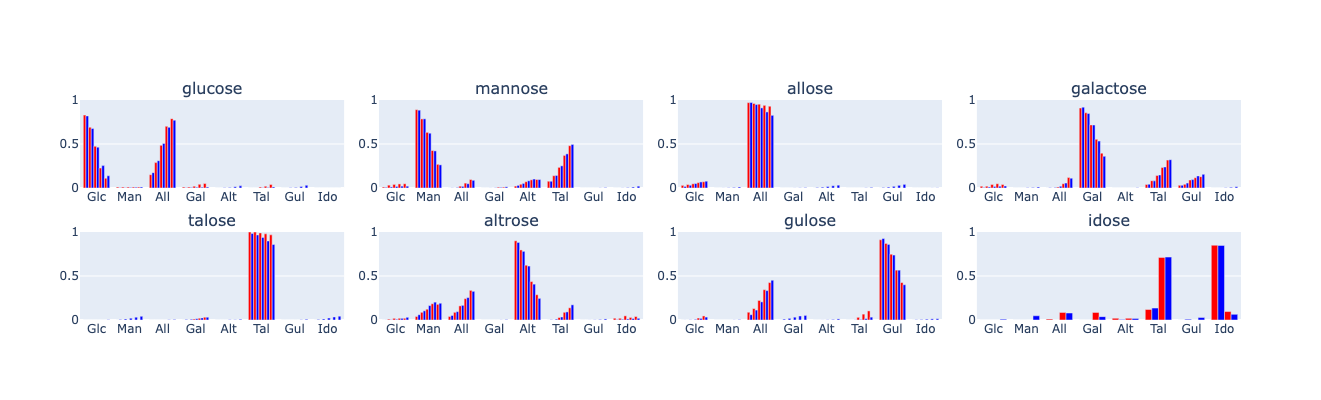

In [91]:
run_simulations()
plot() # red is experiment, blue is simulated

In [83]:
network = create_network(parameters)

# run simulations
losses = []
report_string = ""
for i,run in enumerate(experimental_runs):
    initial_concentrations_dict = {
        run.starting_sugar : 0.2,
        catalyst_active : 0.2*0.02,
    }
    concentrations_df = network.simulate_timecourse(initial_concentrations_dict, t_span, t_eval)
    loss = loss_function(run, concentrations_df)
    report_string += f"{sugar_abbreviations[i].strip()} : {loss:.4f}   "
    losses.append(loss)

# aggregate losses
loss = rms(losses) #+ np.std(losses)
print(f"{report_string}  ::: {loss:8.4f}")

Glc : 0.0159   Man : 0.0106   All : 0.0245   Gal : 0.0123   Alt : 0.0274   Tal : 0.0163   Gul : 0.0216   Ido : 0.0212     :::   0.0195


In [84]:
parameters.pretty_print()

Name                                          Value      Min      Max   Stderr     Vary     Expr Brute_Step
All_Gul_log10_base_rate_constant             -2.398       -3       -1     None     True     None     None
All_Gul_log10_selectivity                    -1.041       -2        2     None     True     None     None
Alt_All_log10_base_rate_constant             -2.432       -3       -1     None     True     None     None
Alt_All_log10_selectivity                         1       -2        2     None     True     None     None
Alt_Ido_log10_base_rate_constant                 -3       -3       -1     None     True     None     None
Alt_Ido_log10_selectivity                         0       -2        2     None     True     None     None
Gal_Tal_log10_base_rate_constant             -2.523       -3       -1     None     True     None     None
Gal_Tal_log10_selectivity                         1       -2        2     None     True     None     None
Glc_All_log10_base_rate_constant            

In [85]:
# simulate each experimental run for one set of parameters
def trial(x):
    global iteration, best_loss
    iteration += 1
    network = create_network(x)

    # run simulations
    losses = []
    #x.pretty_print()
    report_string = ""
    for i,run in enumerate(experimental_runs, start=1):
        initial_concentrations_dict = {
            run.starting_sugar : 0.2,
            catalyst_active : 0.2*0.02,
        }
        concentrations_df = network.simulate_timecourse(initial_concentrations_dict, t_span, t_eval)
        loss = loss_function(run, concentrations_df)
        report_string += f"{loss:8.4f} "
        losses.append(loss)

    # aggregate losses
    loss = rms(losses) #+ np.std(losses)
    if not best_loss or loss < best_loss:
        best_loss = loss

    # report progress
    print(f"{report_string}  ::: {loss:8.4f} (best={best_loss:8.4f})  (iteration={iteration})", end="\r", flush=True)
    if iteration == 1:
        print()
    return loss

In [86]:
# run the optimization
# def iter_cb(parameters, iteration, residual):
#     print(f"iteration {iteration:5d}   loss = {residual:12.4f}", flush=True)
iteration = 0
best_loss = None
results = lmfit.minimize(trial, parameters, method="cg", max_nfev=500)
#results = lmfit.minimize(trial, results.params, method="cg", max_nfev=2000)

  0.0159   0.0106   0.0245   0.0123   0.0274   0.0163   0.0216   0.0212   :::   0.0195 (best=  0.0195)  (iteration=1)


In [87]:
print(lmfit.fit_report(results))
print()
print_count = 0
# params is the best params (see lmfit docs)
for name, param in results.params.items():
    print_count += 1
    value = np.power(10.0, param.value)
    if "rate" in name:
        value = value*1e6
    if print_count % 2:
        print(f"{name:42s} {value:10.0f}   ", end="")
    else:
        if value < 1:
            value = -1/value
        print(f"{value:10.0f}")
print()

[[Fit Statistics]]
    # fitting method   = CG
    # function evals   = 501
    # data points      = 1
    # variables        = 24
    chi-square         = 2.0489e-04
    reduced chi-square = 2.0489e-04
    Akaike info crit   = 39.5069837
    Bayesian info crit = -8.49301634
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    Glc_All_log10_base_rate_constant:          -2.03261936 (init = -1.886057)
    Glc_All_log10_selectivity:                  1.23298724 (init = 1)
    Glc_Gal_log10_base_rate_constant:          -3.00000000 (init = -3)
    Glc_Gal_log10_selectivity:                 -0.39024911 (init = -0.30103)
    Glc_Man_log10_base_rate_constant:          -3.00000000 (init = -3)
    Glc_Man_log10_selectivity:                 -0.69597000 (init 

In [ ]:
def create_deuterated_network(x, abundance=0.7, commitment=1000.0):
    reactions_dict = {}

    for connection in CONNECTIONS:
        base_rate_constant = np.power(10, x[f"{connection}_log10_base_rate_constant"])
        selectivity = np.power(10, x[f"{connection}_log10_selectivity"])
        add_connection(reactions_dict, connection, base_rate_constant, selectivity)

    catalyst_deactivation_reaction = Reaction(catalyst_active, catalyst_dead, reversible=False)
    reactions_dict[catalyst_deactivation_reaction] = np.power(10.0,x["log10_catalyst_deactivation_rate_constant"])
    
    network = Network(reactions_dict, fixed_concentrations=None)
    return network